In [1]:
!pip3 install datasets transformers -q

In [3]:
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder

In [4]:
go_emotions = load_dataset("go_emotions")
data = go_emotions.data

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
train, valid, test = data["train"].to_pandas(), data["validation"].to_pandas(), data["test"].to_pandas()

In [6]:
train_text = train["text"].tolist()
train_labels = train["labels"].tolist()
valid_text = valid["text"].tolist()
valid_labels = valid["labels"].tolist()

In [7]:
text = train_text+valid_text
labels = train_labels+valid_labels

In [8]:
text = pd.DataFrame(text)
text.rename({0: 'text'}, axis=1, inplace=True)
labels= pd.DataFrame(labels)
labels.rename({0: 'emotions'}, axis=1, inplace=True)

In [9]:
text.head()

,text
0,My favourite food is anything I didn't have to...
1,"Now if he does off himself, everyone will thin..."
2,WHY THE FUCK IS BAYLESS ISOING
3,To make her feel threatened
4,Dirty Southern Wankers


In [10]:
labels.head()

,emotions,1,2,3,4
0,27,NaN,NaN,NaN,NaN
1,27,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN
3,14,NaN,NaN,NaN,NaN
4,3,NaN,NaN,NaN,NaN


In [11]:
labels = labels.drop([1,2,3,4], axis=1)

In [12]:
data = pd.concat([text, labels], axis=1)

In [13]:
data.head()

,text,emotions
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [14]:
mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

n_labels = len(mapping)

In [15]:
data.head()

,text,emotions
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [16]:
emotions=[]
for i in data.emotions:
    emotions.append(mapping[i])
  
data['emotions']=emotions

In [17]:
data.head()

,text,emotions
0,My favourite food is anything I didn't have to...,neutral
1,"Now if he does off himself, everyone will thin...",neutral
2,WHY THE FUCK IS BAYLESS ISOING,anger
3,To make her feel threatened,fear
4,Dirty Southern Wankers,annoyance


In [18]:
max_len = 0
all_len=[]
for i in data.text:
    all_len.append(len(i))
    max_len=max(max_len,len(i))
print(max_len)    

703


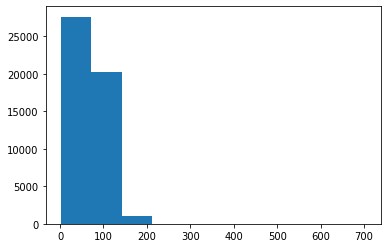

In [19]:
from matplotlib import pyplot as plt
plt.hist(all_len)
plt.show()

In [20]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [21]:
len(data.loc[0].text.split(' '))

11

In [22]:
len(data)

48836

In [23]:
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 200].copy()

In [24]:
data.head()

,text,emotions,token_size
0,My favourite food is anything I didn't have to...,neutral,11
1,"Now if he does off himself, everyone will thin...",neutral,20
2,WHY THE FUCK IS BAYLESS ISOING,anger,6
3,To make her feel threatened,fear,5
4,Dirty Southern Wankers,annoyance,3


In [25]:
data['token_size'].describe()

count    48836.000000
mean        12.897453
std          6.738225
min          1.000000
25%          7.000000
50%         12.000000
75%         18.000000
max         33.000000
Name: token_size, dtype: float64

In [26]:
inputs = ConstructVocab(data["text"].values.tolist())

In [27]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [28]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [29]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

33


In [30]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [31]:
# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [32]:
input_tensor[0:2]

[array([12922, 32633, 33405, 38438, 21180, 10602, 29323, 35848, 56020,
        27258, 42732,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]),
 array([13396, 37260, 35892, 29964, 43860, 36389, 31702, 59248, 55556,
        36259, 35867, 19663, 39519, 50661, 59396, 45403, 38058, 43847,
        20033, 28465,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0])]

In [33]:
### convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [34]:
target_tensor[0:2] 

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0]])

In [35]:
data[0:2]

,text,emotions,token_size
0,My favourite food is anything I didn't have to...,neutral,11
1,"Now if he does off himself, everyone will thin...",neutral,20


In [36]:
get_emotion = lambda t: np.argmax(t)

In [37]:
get_emotion(target_tensor[0])

20

In [38]:
emotion_dict=mapping
emotion_dict[get_emotion(target_tensor[0])]

'optimism'

In [39]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(39068, 39068, 4884, 4884, 4884, 4884)

In [40]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

In [41]:
from torch.utils.data import Dataset, DataLoader

In [42]:
# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [43]:
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)

train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [44]:
val_dataset.batch_size

64

In [45]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden  

In [46]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# obtain one sample from the data iterator
it = iter(train_dataset)
x, y, x_len = next(it)

# sort the batch first to be able to use with pac_pack sequence
xs, ys, lens = sort_batch(x, y, x_len)

print("Input size: ", xs.size())

output, _ = model(xs.to(device), lens, device)
print(output.size())

Input size:  torch.Size([33, 64])
torch.Size([64, 28])


In [48]:
### Enabling cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

### loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    # convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target) 
    return loss   #TODO: refer the parameter of these functions as the same
    
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [257]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        predictions, _ = model(inp.permute(1 ,0).to(device), lens, device) # TODO:don't need _   
              
        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))
            
    ### Validating
    # for (batch, (inp, targ, lens)) in enumerate(val_dataset):        
    #     predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
    #     batch_accuracy = accuracy(targ.to(device), predictions)
    #     val_accuracy += batch_accuracy
    
    # print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
    #                                                          total_loss / TRAIN_N_BATCH, 
    #                                                          train_accuracy / TRAIN_N_BATCH,
    #                                                          val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.1202
Epoch 1 Batch 100 Val. Loss 0.0925
Epoch 1 Batch 200 Val. Loss 0.0866
Epoch 1 Batch 300 Val. Loss 0.0875
Epoch 1 Batch 400 Val. Loss 0.0775
Epoch 1 Batch 500 Val. Loss 0.0722
Epoch 1 Batch 600 Val. Loss 0.0820
Epoch 1 Loss 0.0865 -- Train Acc. 38.2915 -- Val Acc. 44.8602
Time taken for 1 epoch 833.0982940196991 sec

Epoch 2 Batch 0 Val. Loss 0.0632
Epoch 2 Batch 100 Val. Loss 0.0716
Epoch 2 Batch 200 Val. Loss 0.0711
Epoch 2 Batch 300 Val. Loss 0.0567
Epoch 2 Batch 400 Val. Loss 0.0667
Epoch 2 Batch 500 Val. Loss 0.0581
Epoch 2 Batch 600 Val. Loss 0.0536
Epoch 2 Loss 0.0676 -- Train Acc. 48.7398 -- Val Acc. 46.5666
Time taken for 1 epoch 821.3387022018433 sec

Epoch 3 Batch 0 Val. Loss 0.0505
Epoch 3 Batch 100 Val. Loss 0.0614
Epoch 3 Batch 200 Val. Loss 0.0465
Epoch 3 Batch 300 Val. Loss 0.0555
Epoch 3 Batch 400 Val. Loss 0.0593
Epoch 3 Batch 500 Val. Loss 0.0618
Epoch 3 Batch 600 Val. Loss 0.0445
Epoch 3 Loss 0.0520 -- Train Acc. 58.0405 -- Val Acc. 4

In [258]:
model.parameters

<bound method Module.parameters of EmoGRU(
  (embedding): Embedding(61268, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (gru): GRU(256, 1024)
  (fc): Linear(in_features=1024, out_features=28, bias=True)
)>

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [50]:
device

device(type='cpu')

In [51]:
model.load_state_dict(torch.load("/content/model.pth"))
model.eval()

EmoGRU(
  (embedding): Embedding(61268, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (gru): GRU(256, 1024)
  (fc): Linear(in_features=1024, out_features=28, bias=True)
)

In [52]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

#device = "cuda" # we don't need GPU to do testing
model.to("cpu")

for (batch, (inp, targ, lens)) in enumerate(test_dataset):          
    predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
    batch_accuracy = accuracy(targ.to(device), predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.cpu().detach().numpy() / TEST_N_BATCH)

Test Accuracy:  87.21217105263158


In [260]:
torch.save(model.state_dict(), "/content/model.pth")